In [1]:
# MNIST and CelebA datasets will be used

In [38]:
directory='./data'

import helper
helper.download_extract('mnist', directory)
helper.download_extract('celeba', directory)

Found mnist Data
Found celeba Data


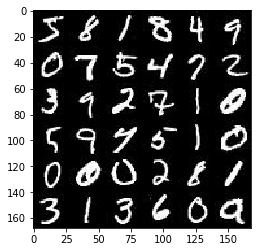

In [39]:
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

im_show=36
im_mnist=helper.get_batch(glob(os.path.join(directory, 'mnist/*.jpg'))[:im_show], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(im_mnist, 'L'), cmap='gray')

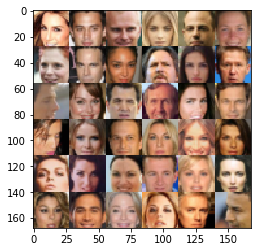

In [8]:
im_celeba=helper.get_batch(glob(os.path.join(directory, 'img_align_celeba/*.jpg'))[:im_show], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(im_celeba, 'RGB'))

In [ ]:
# The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images
# The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.
# The MNIST images are black and white images with a single color channel while the CelebA images have 3 color channels (RGB color channel).

In [40]:
import tensorflow as tf
from distutils.version import LooseVersion
import warnings
# check tensorflow version
assert LooseVersion(tf.__version__)>=LooseVersion('1.0'), 'Please use Tensorflow version 1.0 or newer. You current version is {}'.format(tf.__version__)
print ("Tensorflow version: {}".format(tf.__version__))
#check GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found')
else:
    print ('GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow version: 1.0.1


c:\python35\lib\site-packages\ipykernel_launcher.py:9: UserWarning: No GPU found
  if __name__ == '__main__':


In [41]:
# create placeholder 
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_images=tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='inputs_images')
    inputs_z=tf.placeholder(tf.float32, shape=(None, z_dim), name='inputs_z')
    learning_rate=tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return inputs_images, inputs_z, learning_rate

tests.test_model_inputs(model_inputs)

Tests Passed


In [12]:
# create a discriminator neural network that discriminates on images.
# Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. 
def discriminator(images, reuse=False):
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3
        conv1=tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1=tf.maximum(alpha*conv1, conv1)
        # 14*14*64
        conv2=tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        batnorm2=tf.layers.batch_normalization(conv2, training=True)
        relu2=tf.maximum(alpha*batnorm2, batnorm2)
        # 7*7*128
        conv3=tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        batnorm3=tf.layers.batch_normalization(conv3, training=True)
        relu3=tf.maximum(alpha*batnorm3, batnorm3)
        # 4*4*256
        # Flatten, fully connected
        flatten=tf.reshape(relu3, (-1, 4*4*256))
        logits=tf.layers.dense(flatten, 1)
        output=tf.sigmoid(logits)
        
        return output, logits

tests.test_discriminator(discriminator, tf)

Tests Passed


In [42]:
# Implement generator to generate an image using z.
# reuse the variabes in the neural network. Use tf.variable_scope with a scope name of "generator" to allow the variables to be reused. 
# return the generated 28 x 28 x out_channel_dim images.

def generator(z, out_channel_dim, is_train=True):
    alpha=0.2
    with tf.variable_scope('generator', reuse=not is_train):
        de_fully_conn1=tf.layers.dense(z, 7*7*256)
        de_fully_conn1=tf.reshape(de_fully_conn1, (-1, 7, 7, 256))
        de_fully_conn1=tf.layers.batch_normalization(de_fully_conn1, training=is_train)
        # 7*7*256
        de_conv2=tf.layers.conv2d_transpose(de_fully_conn1, 128, 5, strides=2, padding='same')
        de_conv2=tf.layers.batch_normalization(de_conv2, training=is_train)
        de_conv2=tf.maximum(alpha*de_conv2, de_conv2)
        # 14*14*128
        de_conv3=tf.layers.conv2d_transpose(de_conv2, 64, 5, strides=2, padding='same')
        de_conv3=tf.layers.batch_normalization(de_conv3, training=is_train)
        de_conv3=tf.maximum(alpha*de_conv3, de_conv3)
        # 28*28*64
        
        logits=tf.layers.conv2d_transpose(de_conv3, out_channel_dim, 5, strides=1, padding='same')
        # 28*28*out_channel_dim
        output=tf.tanh(logits)
        
        return output

tests.test_generator(generator, tf)        

Tests Passed


In [43]:
# Implement model_loss to build the GANs for training and calculate the loss

def model_loss(input_real, input_z, out_channel_dim):
    gen_model=generator(input_z, out_channel_dim)
    discri_output_real, discri_logits_real=discriminator(input_real)
    discri_output_fake, discri_logits_fake=discriminator(gen_model, reuse=True)
    
    discri_loss_real=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discri_logits_real, labels=tf.ones_like(discri_output_real)))
    discri_loss_fake=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discri_logits_fake, labels=tf.zeros_like(discri_output_fake)))
    gen_loss=tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=discri_logits_fake, labels=tf.ones_like(discri_output_fake)))
    discri_loss=discri_loss_real+discri_loss_fake
    
    return discri_loss, gen_loss

tests.test_model_loss(model_loss)

Tests Passed


In [44]:
# Implement model_opt to create the optimization operations for the GANs
# Use tf.trainable_variables to get all the trainable variables.
# Filter the variables with names that are in the discriminator and generator scope names.

def model_opt(discri_loss, gen_loss, learning_rate, beta1):
    # beta1: The exponential decay rate for the 1st moment in the optimizer
    
    # filter
    train_vars=tf.trainable_variables()
    discri_vars=[var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars=[var for var in train_vars if var.name.startswith('generator')]
    
    #optimizer
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discri_train_ops=tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(discri_loss, var_list=discri_vars)
        gen_train_ops=tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(gen_loss, var_list=gen_vars)
        
    return discri_train_ops, gen_train_ops

tests.test_model_opt(model_opt, tf)

Tests Passed


In [45]:
# Neural Network Training, show the current output of the generator during training
import numpy as np
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    sess: TensorFlow session
    n_images: Number of Images to display
    input_z: Input Z Tensor
    out_channel_dim: The number of channels in the output image
    image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap=None if image_mode=='RGB' else 'gray'
    z_dim=input_z.get_shape().as_list()[-1]
    exmp_z=np.random.uniform(-1, 1, size=[n_images, z_dim])
    
    samples=sess.run(generator(input_z, out_channel_dim, False), feed_dict={input_z: exmp_z})
    image_grid=helper.images_square_grid(samples, image_mode)
    pyplot.imshow(image_grid, cmap=cmap)
    pyplot.show()

In [46]:
# Implement train to build and train the GANs. 
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """

    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    print_interval=10
    show_interval=100
    n_images=16
    sample_num, width, height, channel=data_shape
    inputs_real, inputs_z, learning_rate_=model_inputs(width, height, channel, z_dim)
    discri_loss, gen_loss=model_loss(inputs_real, inputs_z, channel)
    discri_train_ops, gen_train_ops=model_opt(discri_loss, gen_loss, learning_rate_, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(epoch_count):
            for batches in get_batches(batch_size):
                steps+=1
                # Scales the images from -1 to 1
                batches=batches*2
                # sample z for generator
                batches_z=np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # run optimizer
                _=sess.run(discri_train_ops, feed_dict={inputs_real: batches, inputs_z: batches_z, learning_rate_: learning_rate})
                _=sess.run(gen_train_ops, feed_dict={inputs_real: batches, inputs_z: batches_z, learning_rate_: learning_rate})
                
                # output
                if steps%print_interval==0:
                    train_loss_discri = discri_loss.eval({inputs_z: batches_z, inputs_real: batches})
                    train_loss_gen = gen_loss.eval({inputs_z: batches_z})
                    print ('Epoch {} out of {}'.format(epoch, epoch_count),
                          'Discriminator loss is: {:.4f}'.format(train_loss_discri),
                          'Generator loss is: {:.4f}'.format(train_loss_gen))
                
                if steps%show_interval==0:
                    show_generator_output(sess, n_images, inputs_z, channel, data_image_mode)

Epoch 0 out of 2 Discriminator loss is: 0.4519 Generator loss is: 5.9390
Epoch 0 out of 2 Discriminator loss is: 0.9952 Generator loss is: 2.8660
Epoch 0 out of 2 Discriminator loss is: 2.0108 Generator loss is: 2.6749
Epoch 0 out of 2 Discriminator loss is: 2.0854 Generator loss is: 1.7869
Epoch 0 out of 2 Discriminator loss is: 2.1166 Generator loss is: 0.2018
Epoch 0 out of 2 Discriminator loss is: 1.8693 Generator loss is: 0.7949
Epoch 0 out of 2 Discriminator loss is: 1.5515 Generator loss is: 0.3355
Epoch 0 out of 2 Discriminator loss is: 2.1810 Generator loss is: 2.4750
Epoch 0 out of 2 Discriminator loss is: 1.3461 Generator loss is: 0.9142
Epoch 0 out of 2 Discriminator loss is: 0.9456 Generator loss is: 0.9755


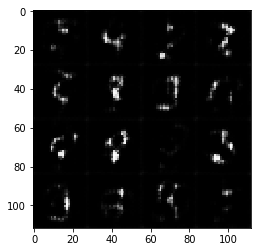

Epoch 0 out of 2 Discriminator loss is: 1.2678 Generator loss is: 0.4518
Epoch 0 out of 2 Discriminator loss is: 0.9399 Generator loss is: 0.7848
Epoch 0 out of 2 Discriminator loss is: 1.2047 Generator loss is: 1.3334
Epoch 0 out of 2 Discriminator loss is: 0.9971 Generator loss is: 2.3531
Epoch 0 out of 2 Discriminator loss is: 1.0618 Generator loss is: 0.7068
Epoch 0 out of 2 Discriminator loss is: 1.1005 Generator loss is: 0.6863
Epoch 0 out of 2 Discriminator loss is: 1.0556 Generator loss is: 1.1557
Epoch 0 out of 2 Discriminator loss is: 1.2502 Generator loss is: 0.5510
Epoch 0 out of 2 Discriminator loss is: 1.6082 Generator loss is: 0.3743
Epoch 0 out of 2 Discriminator loss is: 1.3427 Generator loss is: 1.1788


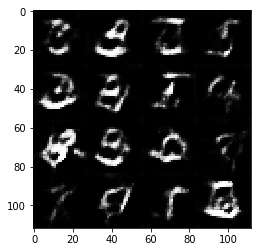

Epoch 0 out of 2 Discriminator loss is: 1.1614 Generator loss is: 1.0610
Epoch 0 out of 2 Discriminator loss is: 1.3414 Generator loss is: 0.9765
Epoch 0 out of 2 Discriminator loss is: 1.7329 Generator loss is: 0.3203
Epoch 0 out of 2 Discriminator loss is: 1.2675 Generator loss is: 0.6135
Epoch 0 out of 2 Discriminator loss is: 1.1327 Generator loss is: 1.0019
Epoch 0 out of 2 Discriminator loss is: 1.0568 Generator loss is: 0.9428
Epoch 0 out of 2 Discriminator loss is: 1.0882 Generator loss is: 0.8059
Epoch 0 out of 2 Discriminator loss is: 1.2864 Generator loss is: 0.6222
Epoch 0 out of 2 Discriminator loss is: 1.3083 Generator loss is: 0.5091
Epoch 0 out of 2 Discriminator loss is: 1.3461 Generator loss is: 1.4626


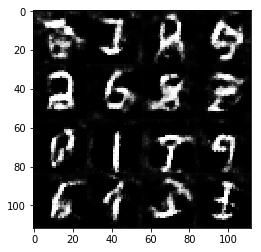

Epoch 0 out of 2 Discriminator loss is: 1.0792 Generator loss is: 0.8963
Epoch 0 out of 2 Discriminator loss is: 1.2135 Generator loss is: 1.1054
Epoch 0 out of 2 Discriminator loss is: 1.0711 Generator loss is: 0.7788
Epoch 0 out of 2 Discriminator loss is: 1.1134 Generator loss is: 0.6515
Epoch 0 out of 2 Discriminator loss is: 1.0817 Generator loss is: 1.6829
Epoch 0 out of 2 Discriminator loss is: 1.0195 Generator loss is: 1.0571
Epoch 0 out of 2 Discriminator loss is: 1.3169 Generator loss is: 0.5296
Epoch 0 out of 2 Discriminator loss is: 0.7869 Generator loss is: 1.3947
Epoch 0 out of 2 Discriminator loss is: 1.3527 Generator loss is: 0.6700
Epoch 0 out of 2 Discriminator loss is: 1.2802 Generator loss is: 1.0044


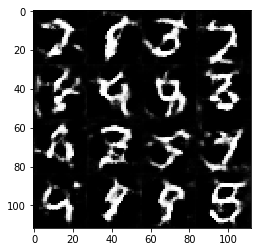

Epoch 0 out of 2 Discriminator loss is: 1.2065 Generator loss is: 0.6249
Epoch 0 out of 2 Discriminator loss is: 0.9780 Generator loss is: 1.1734
Epoch 0 out of 2 Discriminator loss is: 1.1575 Generator loss is: 0.6377
Epoch 0 out of 2 Discriminator loss is: 1.1380 Generator loss is: 0.6060
Epoch 0 out of 2 Discriminator loss is: 0.9740 Generator loss is: 0.9593
Epoch 0 out of 2 Discriminator loss is: 1.2610 Generator loss is: 0.5267
Epoch 0 out of 2 Discriminator loss is: 1.1984 Generator loss is: 0.6021
Epoch 0 out of 2 Discriminator loss is: 1.0230 Generator loss is: 0.8058
Epoch 0 out of 2 Discriminator loss is: 1.2942 Generator loss is: 1.7201
Epoch 0 out of 2 Discriminator loss is: 1.0417 Generator loss is: 0.6734


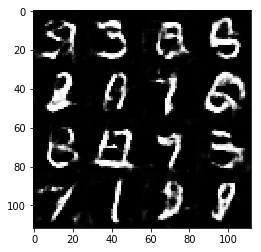

Epoch 0 out of 2 Discriminator loss is: 1.4272 Generator loss is: 2.3023
Epoch 0 out of 2 Discriminator loss is: 1.1529 Generator loss is: 0.5703
Epoch 0 out of 2 Discriminator loss is: 1.0349 Generator loss is: 1.4598
Epoch 0 out of 2 Discriminator loss is: 1.1626 Generator loss is: 0.7083
Epoch 0 out of 2 Discriminator loss is: 0.9910 Generator loss is: 1.3211
Epoch 0 out of 2 Discriminator loss is: 1.0706 Generator loss is: 0.8483
Epoch 0 out of 2 Discriminator loss is: 1.8419 Generator loss is: 0.2637
Epoch 0 out of 2 Discriminator loss is: 0.9714 Generator loss is: 0.8311
Epoch 0 out of 2 Discriminator loss is: 0.8620 Generator loss is: 1.0410
Epoch 0 out of 2 Discriminator loss is: 0.8576 Generator loss is: 0.8799


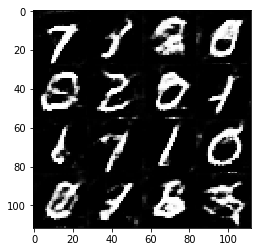

Epoch 0 out of 2 Discriminator loss is: 2.0254 Generator loss is: 2.6107
Epoch 0 out of 2 Discriminator loss is: 0.8644 Generator loss is: 1.0187
Epoch 0 out of 2 Discriminator loss is: 1.3907 Generator loss is: 0.4224
Epoch 0 out of 2 Discriminator loss is: 0.9927 Generator loss is: 0.6567
Epoch 0 out of 2 Discriminator loss is: 1.1869 Generator loss is: 1.5812
Epoch 0 out of 2 Discriminator loss is: 0.9442 Generator loss is: 0.8897
Epoch 0 out of 2 Discriminator loss is: 0.8824 Generator loss is: 0.9490
Epoch 0 out of 2 Discriminator loss is: 1.3419 Generator loss is: 0.6500
Epoch 0 out of 2 Discriminator loss is: 0.8742 Generator loss is: 0.9156
Epoch 0 out of 2 Discriminator loss is: 1.5621 Generator loss is: 0.3914


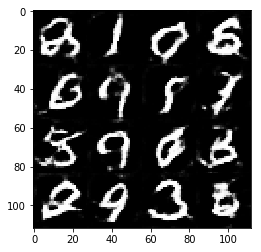

Epoch 0 out of 2 Discriminator loss is: 1.2246 Generator loss is: 0.5117
Epoch 0 out of 2 Discriminator loss is: 1.1830 Generator loss is: 0.6269
Epoch 0 out of 2 Discriminator loss is: 0.9661 Generator loss is: 2.4555
Epoch 0 out of 2 Discriminator loss is: 0.9305 Generator loss is: 1.0147
Epoch 0 out of 2 Discriminator loss is: 1.0043 Generator loss is: 0.7413
Epoch 0 out of 2 Discriminator loss is: 1.3521 Generator loss is: 0.4905
Epoch 0 out of 2 Discriminator loss is: 0.8835 Generator loss is: 0.9731
Epoch 0 out of 2 Discriminator loss is: 1.2208 Generator loss is: 0.5863
Epoch 0 out of 2 Discriminator loss is: 1.1729 Generator loss is: 0.6659
Epoch 0 out of 2 Discriminator loss is: 1.0285 Generator loss is: 0.7706


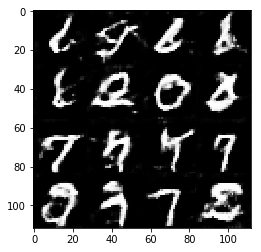

Epoch 0 out of 2 Discriminator loss is: 0.7444 Generator loss is: 1.2708
Epoch 0 out of 2 Discriminator loss is: 0.9214 Generator loss is: 0.7923
Epoch 0 out of 2 Discriminator loss is: 0.9780 Generator loss is: 0.7582
Epoch 0 out of 2 Discriminator loss is: 0.5165 Generator loss is: 1.3187
Epoch 0 out of 2 Discriminator loss is: 0.7290 Generator loss is: 1.0615
Epoch 0 out of 2 Discriminator loss is: 1.8344 Generator loss is: 0.4379
Epoch 0 out of 2 Discriminator loss is: 1.2849 Generator loss is: 1.0786
Epoch 0 out of 2 Discriminator loss is: 1.0367 Generator loss is: 0.7054
Epoch 0 out of 2 Discriminator loss is: 1.1840 Generator loss is: 0.5386
Epoch 0 out of 2 Discriminator loss is: 1.6611 Generator loss is: 0.3309


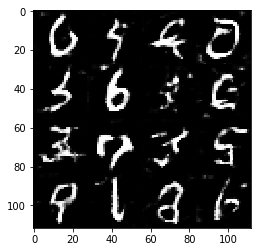

Epoch 0 out of 2 Discriminator loss is: 0.8505 Generator loss is: 1.0957
Epoch 0 out of 2 Discriminator loss is: 0.7652 Generator loss is: 1.0134
Epoch 0 out of 2 Discriminator loss is: 0.6879 Generator loss is: 1.3830
Epoch 1 out of 2 Discriminator loss is: 1.5833 Generator loss is: 0.3654
Epoch 1 out of 2 Discriminator loss is: 1.0734 Generator loss is: 0.7907
Epoch 1 out of 2 Discriminator loss is: 0.9185 Generator loss is: 0.9829
Epoch 1 out of 2 Discriminator loss is: 0.9051 Generator loss is: 1.2638
Epoch 1 out of 2 Discriminator loss is: 1.2150 Generator loss is: 0.5666
Epoch 1 out of 2 Discriminator loss is: 1.0504 Generator loss is: 0.7994
Epoch 1 out of 2 Discriminator loss is: 0.8983 Generator loss is: 1.5851


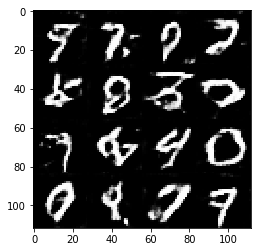

Epoch 1 out of 2 Discriminator loss is: 0.8346 Generator loss is: 1.0962
Epoch 1 out of 2 Discriminator loss is: 0.6412 Generator loss is: 1.1186
Epoch 1 out of 2 Discriminator loss is: 0.4090 Generator loss is: 2.0298
Epoch 1 out of 2 Discriminator loss is: 1.9964 Generator loss is: 0.2524
Epoch 1 out of 2 Discriminator loss is: 0.7114 Generator loss is: 1.3115
Epoch 1 out of 2 Discriminator loss is: 1.2429 Generator loss is: 0.5274
Epoch 1 out of 2 Discriminator loss is: 0.6546 Generator loss is: 1.2809
Epoch 1 out of 2 Discriminator loss is: 0.8728 Generator loss is: 0.8210
Epoch 1 out of 2 Discriminator loss is: 1.0079 Generator loss is: 0.7770
Epoch 1 out of 2 Discriminator loss is: 1.0062 Generator loss is: 0.7544


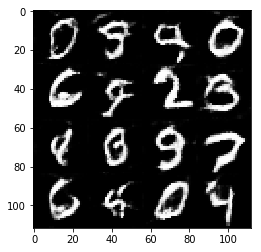

Epoch 1 out of 2 Discriminator loss is: 0.5331 Generator loss is: 1.5085
Epoch 1 out of 2 Discriminator loss is: 1.0533 Generator loss is: 0.6602
Epoch 1 out of 2 Discriminator loss is: 0.5032 Generator loss is: 1.7325
Epoch 1 out of 2 Discriminator loss is: 1.2415 Generator loss is: 0.5049
Epoch 1 out of 2 Discriminator loss is: 1.1977 Generator loss is: 0.6046
Epoch 1 out of 2 Discriminator loss is: 0.8362 Generator loss is: 1.7398
Epoch 1 out of 2 Discriminator loss is: 0.8847 Generator loss is: 0.9748
Epoch 1 out of 2 Discriminator loss is: 1.0666 Generator loss is: 0.7113
Epoch 1 out of 2 Discriminator loss is: 1.4071 Generator loss is: 0.4894
Epoch 1 out of 2 Discriminator loss is: 1.2399 Generator loss is: 0.7020


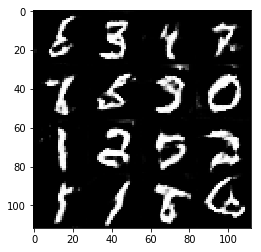

Epoch 1 out of 2 Discriminator loss is: 0.7818 Generator loss is: 1.3048
Epoch 1 out of 2 Discriminator loss is: 0.6495 Generator loss is: 1.7411
Epoch 1 out of 2 Discriminator loss is: 1.2018 Generator loss is: 0.6089
Epoch 1 out of 2 Discriminator loss is: 0.8053 Generator loss is: 1.1773
Epoch 1 out of 2 Discriminator loss is: 0.8914 Generator loss is: 1.9039
Epoch 1 out of 2 Discriminator loss is: 0.8009 Generator loss is: 1.1469
Epoch 1 out of 2 Discriminator loss is: 1.0098 Generator loss is: 0.8421
Epoch 1 out of 2 Discriminator loss is: 0.8027 Generator loss is: 1.0217
Epoch 1 out of 2 Discriminator loss is: 0.4505 Generator loss is: 1.8945
Epoch 1 out of 2 Discriminator loss is: 0.6781 Generator loss is: 1.1658


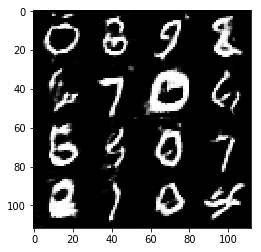

Epoch 1 out of 2 Discriminator loss is: 0.7098 Generator loss is: 1.0511
Epoch 1 out of 2 Discriminator loss is: 1.0405 Generator loss is: 0.6944
Epoch 1 out of 2 Discriminator loss is: 0.6949 Generator loss is: 1.4117
Epoch 1 out of 2 Discriminator loss is: 0.6102 Generator loss is: 1.3727
Epoch 1 out of 2 Discriminator loss is: 0.9109 Generator loss is: 0.9233
Epoch 1 out of 2 Discriminator loss is: 0.7490 Generator loss is: 1.1901
Epoch 1 out of 2 Discriminator loss is: 0.6509 Generator loss is: 1.4874
Epoch 1 out of 2 Discriminator loss is: 0.9229 Generator loss is: 3.7699
Epoch 1 out of 2 Discriminator loss is: 0.8059 Generator loss is: 0.8787
Epoch 1 out of 2 Discriminator loss is: 0.5214 Generator loss is: 1.7325


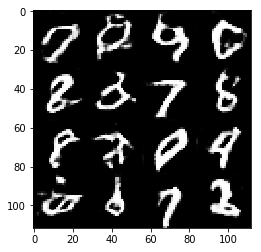

Epoch 1 out of 2 Discriminator loss is: 0.9553 Generator loss is: 2.1256
Epoch 1 out of 2 Discriminator loss is: 0.9070 Generator loss is: 1.4328
Epoch 1 out of 2 Discriminator loss is: 1.0700 Generator loss is: 0.6475
Epoch 1 out of 2 Discriminator loss is: 0.5869 Generator loss is: 1.1660
Epoch 1 out of 2 Discriminator loss is: 0.7752 Generator loss is: 1.5411
Epoch 1 out of 2 Discriminator loss is: 0.6658 Generator loss is: 1.2238
Epoch 1 out of 2 Discriminator loss is: 0.5032 Generator loss is: 1.4034
Epoch 1 out of 2 Discriminator loss is: 1.1588 Generator loss is: 0.7265
Epoch 1 out of 2 Discriminator loss is: 0.5253 Generator loss is: 1.9784
Epoch 1 out of 2 Discriminator loss is: 0.4566 Generator loss is: 1.7594


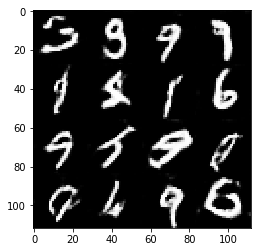

Epoch 1 out of 2 Discriminator loss is: 0.8277 Generator loss is: 2.0206
Epoch 1 out of 2 Discriminator loss is: 0.7644 Generator loss is: 0.9338
Epoch 1 out of 2 Discriminator loss is: 0.5310 Generator loss is: 1.5553
Epoch 1 out of 2 Discriminator loss is: 0.6648 Generator loss is: 1.2498
Epoch 1 out of 2 Discriminator loss is: 1.1669 Generator loss is: 0.6491
Epoch 1 out of 2 Discriminator loss is: 0.8536 Generator loss is: 2.8035
Epoch 1 out of 2 Discriminator loss is: 0.7183 Generator loss is: 1.9216
Epoch 1 out of 2 Discriminator loss is: 0.6225 Generator loss is: 1.1714
Epoch 1 out of 2 Discriminator loss is: 0.8145 Generator loss is: 1.0231
Epoch 1 out of 2 Discriminator loss is: 0.6822 Generator loss is: 1.2670


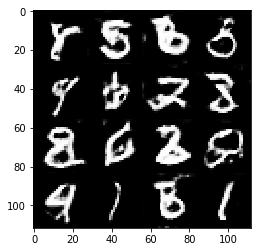

Epoch 1 out of 2 Discriminator loss is: 0.8635 Generator loss is: 0.9454
Epoch 1 out of 2 Discriminator loss is: 0.6884 Generator loss is: 3.5123
Epoch 1 out of 2 Discriminator loss is: 0.8845 Generator loss is: 0.9126
Epoch 1 out of 2 Discriminator loss is: 1.1910 Generator loss is: 0.7244
Epoch 1 out of 2 Discriminator loss is: 0.4866 Generator loss is: 1.8245
Epoch 1 out of 2 Discriminator loss is: 0.6081 Generator loss is: 1.4045
Epoch 1 out of 2 Discriminator loss is: 0.4463 Generator loss is: 1.7914
Epoch 1 out of 2 Discriminator loss is: 0.7541 Generator loss is: 2.7770
Epoch 1 out of 2 Discriminator loss is: 1.1674 Generator loss is: 0.6008
Epoch 1 out of 2 Discriminator loss is: 1.3110 Generator loss is: 0.5395


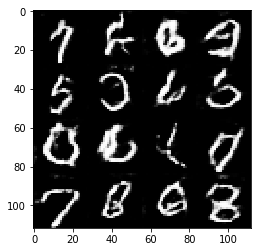

Epoch 1 out of 2 Discriminator loss is: 0.5129 Generator loss is: 1.4894
Epoch 1 out of 2 Discriminator loss is: 1.3282 Generator loss is: 0.5880
Epoch 1 out of 2 Discriminator loss is: 1.6181 Generator loss is: 0.4914
Epoch 1 out of 2 Discriminator loss is: 0.6909 Generator loss is: 1.0818
Epoch 1 out of 2 Discriminator loss is: 0.6197 Generator loss is: 1.3356
Epoch 1 out of 2 Discriminator loss is: 0.4089 Generator loss is: 1.5894
Epoch 1 out of 2 Discriminator loss is: 0.5171 Generator loss is: 1.5823
Epoch 1 out of 2 Discriminator loss is: 1.4729 Generator loss is: 0.5577
Epoch 1 out of 2 Discriminator loss is: 0.1927 Generator loss is: 2.8650
Epoch 1 out of 2 Discriminator loss is: 2.1372 Generator loss is: 0.4051


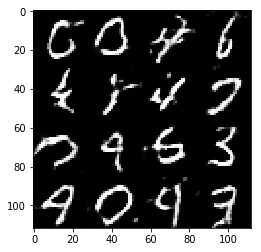

Epoch 1 out of 2 Discriminator loss is: 1.2046 Generator loss is: 0.5725
Epoch 1 out of 2 Discriminator loss is: 1.0572 Generator loss is: 0.7028
Epoch 1 out of 2 Discriminator loss is: 0.6951 Generator loss is: 1.0359
Epoch 1 out of 2 Discriminator loss is: 1.0894 Generator loss is: 0.6892
Epoch 1 out of 2 Discriminator loss is: 0.5699 Generator loss is: 1.7408
Epoch 1 out of 2 Discriminator loss is: 0.6683 Generator loss is: 1.2736
Epoch 1 out of 2 Discriminator loss is: 0.4907 Generator loss is: 1.5302


In [47]:
batch_size=64
z_dim=128
learning_rate=0.001
beta1=0.5

epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(directory, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 0 out of 1 Discriminator loss is: 2.7967 Generator loss is: 1.0284
Epoch 0 out of 1 Discriminator loss is: 0.0118 Generator loss is: 6.9520
Epoch 0 out of 1 Discriminator loss is: 7.3930 Generator loss is: 12.7754
Epoch 0 out of 1 Discriminator loss is: 1.0238 Generator loss is: 1.2301
Epoch 0 out of 1 Discriminator loss is: 2.7566 Generator loss is: 1.2352
Epoch 0 out of 1 Discriminator loss is: 1.0569 Generator loss is: 4.4449
Epoch 0 out of 1 Discriminator loss is: 0.8030 Generator loss is: 1.0444
Epoch 0 out of 1 Discriminator loss is: 0.2078 Generator loss is: 3.1238
Epoch 0 out of 1 Discriminator loss is: 0.3898 Generator loss is: 2.1097
Epoch 0 out of 1 Discriminator loss is: 0.6638 Generator loss is: 1.2994


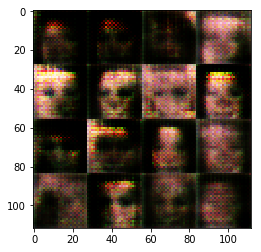

Epoch 0 out of 1 Discriminator loss is: 1.9588 Generator loss is: 0.2042
Epoch 0 out of 1 Discriminator loss is: 1.3708 Generator loss is: 1.7284
Epoch 0 out of 1 Discriminator loss is: 1.7162 Generator loss is: 0.5361
Epoch 0 out of 1 Discriminator loss is: 1.5519 Generator loss is: 0.4118
Epoch 0 out of 1 Discriminator loss is: 1.7167 Generator loss is: 0.4176
Epoch 0 out of 1 Discriminator loss is: 4.1470 Generator loss is: 4.5695
Epoch 0 out of 1 Discriminator loss is: 1.4834 Generator loss is: 0.8118
Epoch 0 out of 1 Discriminator loss is: 1.3584 Generator loss is: 0.5821
Epoch 0 out of 1 Discriminator loss is: 1.4854 Generator loss is: 0.4764
Epoch 0 out of 1 Discriminator loss is: 1.0967 Generator loss is: 0.8372


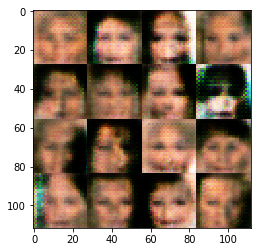

Epoch 0 out of 1 Discriminator loss is: 0.5244 Generator loss is: 1.5769
Epoch 0 out of 1 Discriminator loss is: 0.3117 Generator loss is: 2.6177
Epoch 0 out of 1 Discriminator loss is: 0.9006 Generator loss is: 1.9148
Epoch 0 out of 1 Discriminator loss is: 1.0295 Generator loss is: 0.9287
Epoch 0 out of 1 Discriminator loss is: 1.5454 Generator loss is: 0.4577
Epoch 0 out of 1 Discriminator loss is: 1.2500 Generator loss is: 0.8000
Epoch 0 out of 1 Discriminator loss is: 1.8373 Generator loss is: 1.8049
Epoch 0 out of 1 Discriminator loss is: 1.2531 Generator loss is: 0.6987
Epoch 0 out of 1 Discriminator loss is: 1.3011 Generator loss is: 0.8640
Epoch 0 out of 1 Discriminator loss is: 1.0754 Generator loss is: 0.8899


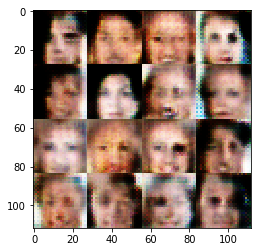

Epoch 0 out of 1 Discriminator loss is: 1.8563 Generator loss is: 2.4992
Epoch 0 out of 1 Discriminator loss is: 1.1531 Generator loss is: 0.8448
Epoch 0 out of 1 Discriminator loss is: 1.4583 Generator loss is: 0.3503
Epoch 0 out of 1 Discriminator loss is: 0.9304 Generator loss is: 1.2232
Epoch 0 out of 1 Discriminator loss is: 1.1024 Generator loss is: 0.9818
Epoch 0 out of 1 Discriminator loss is: 0.4006 Generator loss is: 2.8830
Epoch 0 out of 1 Discriminator loss is: 1.2715 Generator loss is: 0.4652
Epoch 0 out of 1 Discriminator loss is: 1.1335 Generator loss is: 0.7503
Epoch 0 out of 1 Discriminator loss is: 1.8459 Generator loss is: 0.6707
Epoch 0 out of 1 Discriminator loss is: 1.0096 Generator loss is: 1.2647


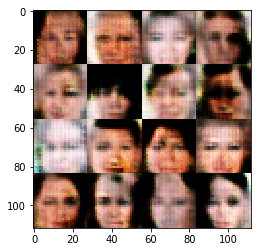

Epoch 0 out of 1 Discriminator loss is: 4.1471 Generator loss is: 4.0608
Epoch 0 out of 1 Discriminator loss is: 0.8352 Generator loss is: 0.9736
Epoch 0 out of 1 Discriminator loss is: 1.3015 Generator loss is: 0.5373
Epoch 0 out of 1 Discriminator loss is: 1.0410 Generator loss is: 0.8665
Epoch 0 out of 1 Discriminator loss is: 1.2206 Generator loss is: 0.5705
Epoch 0 out of 1 Discriminator loss is: 0.7070 Generator loss is: 1.3060
Epoch 0 out of 1 Discriminator loss is: 2.3230 Generator loss is: 2.2625
Epoch 0 out of 1 Discriminator loss is: 0.9066 Generator loss is: 0.6882
Epoch 0 out of 1 Discriminator loss is: 1.6921 Generator loss is: 0.4549
Epoch 0 out of 1 Discriminator loss is: 1.1955 Generator loss is: 0.7076


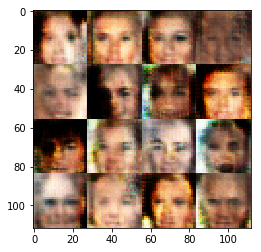

Epoch 0 out of 1 Discriminator loss is: 1.0814 Generator loss is: 0.9684
Epoch 0 out of 1 Discriminator loss is: 0.6352 Generator loss is: 1.6346
Epoch 0 out of 1 Discriminator loss is: 1.4554 Generator loss is: 0.4278
Epoch 0 out of 1 Discriminator loss is: 1.5821 Generator loss is: 0.5238
Epoch 0 out of 1 Discriminator loss is: 1.5237 Generator loss is: 0.6536
Epoch 0 out of 1 Discriminator loss is: 1.1827 Generator loss is: 0.6796
Epoch 0 out of 1 Discriminator loss is: 1.2543 Generator loss is: 0.6826
Epoch 0 out of 1 Discriminator loss is: 1.2601 Generator loss is: 0.8657
Epoch 0 out of 1 Discriminator loss is: 1.2888 Generator loss is: 0.9581
Epoch 0 out of 1 Discriminator loss is: 1.2678 Generator loss is: 0.6709


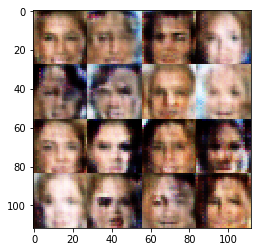

Epoch 0 out of 1 Discriminator loss is: 1.4177 Generator loss is: 0.5338
Epoch 0 out of 1 Discriminator loss is: 1.5312 Generator loss is: 0.7088
Epoch 0 out of 1 Discriminator loss is: 1.4021 Generator loss is: 0.7070
Epoch 0 out of 1 Discriminator loss is: 1.4404 Generator loss is: 0.6764
Epoch 0 out of 1 Discriminator loss is: 1.3722 Generator loss is: 0.6879
Epoch 0 out of 1 Discriminator loss is: 1.3774 Generator loss is: 0.7790
Epoch 0 out of 1 Discriminator loss is: 1.4293 Generator loss is: 0.6924
Epoch 0 out of 1 Discriminator loss is: 1.2943 Generator loss is: 0.7082
Epoch 0 out of 1 Discriminator loss is: 1.4529 Generator loss is: 0.6163
Epoch 0 out of 1 Discriminator loss is: 1.4128 Generator loss is: 0.8148


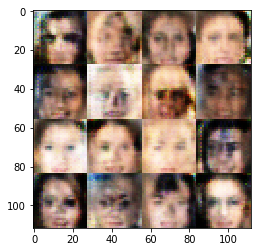

Epoch 0 out of 1 Discriminator loss is: 1.3153 Generator loss is: 0.7993
Epoch 0 out of 1 Discriminator loss is: 1.3929 Generator loss is: 0.6780
Epoch 0 out of 1 Discriminator loss is: 1.3050 Generator loss is: 0.7271
Epoch 0 out of 1 Discriminator loss is: 1.3775 Generator loss is: 0.7465
Epoch 0 out of 1 Discriminator loss is: 1.3320 Generator loss is: 0.7230
Epoch 0 out of 1 Discriminator loss is: 1.4167 Generator loss is: 0.7392
Epoch 0 out of 1 Discriminator loss is: 1.3730 Generator loss is: 0.6711
Epoch 0 out of 1 Discriminator loss is: 1.5052 Generator loss is: 0.6256
Epoch 0 out of 1 Discriminator loss is: 1.3462 Generator loss is: 0.7747
Epoch 0 out of 1 Discriminator loss is: 1.5026 Generator loss is: 0.6344


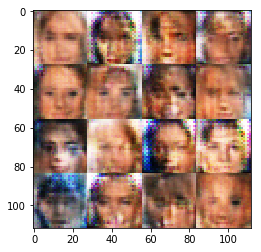

Epoch 0 out of 1 Discriminator loss is: 1.3791 Generator loss is: 0.6600
Epoch 0 out of 1 Discriminator loss is: 1.5455 Generator loss is: 0.6149
Epoch 0 out of 1 Discriminator loss is: 1.5262 Generator loss is: 0.6288
Epoch 0 out of 1 Discriminator loss is: 1.4925 Generator loss is: 0.6615
Epoch 0 out of 1 Discriminator loss is: 1.5444 Generator loss is: 0.6833
Epoch 0 out of 1 Discriminator loss is: 1.4566 Generator loss is: 0.8135
Epoch 0 out of 1 Discriminator loss is: 1.3158 Generator loss is: 0.7287
Epoch 0 out of 1 Discriminator loss is: 1.4266 Generator loss is: 0.7630
Epoch 0 out of 1 Discriminator loss is: 0.8964 Generator loss is: 1.4484
Epoch 0 out of 1 Discriminator loss is: 1.1822 Generator loss is: 0.8639


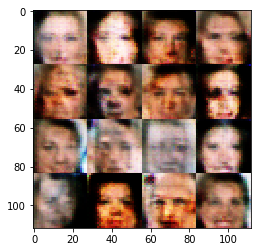

Epoch 0 out of 1 Discriminator loss is: 1.1747 Generator loss is: 1.3397
Epoch 0 out of 1 Discriminator loss is: 1.2320 Generator loss is: 0.7122
Epoch 0 out of 1 Discriminator loss is: 1.4003 Generator loss is: 0.6695
Epoch 0 out of 1 Discriminator loss is: 1.1875 Generator loss is: 0.9615
Epoch 0 out of 1 Discriminator loss is: 1.3377 Generator loss is: 0.8683
Epoch 0 out of 1 Discriminator loss is: 1.5099 Generator loss is: 0.3750
Epoch 0 out of 1 Discriminator loss is: 0.9267 Generator loss is: 0.9406
Epoch 0 out of 1 Discriminator loss is: 1.5209 Generator loss is: 1.7659
Epoch 0 out of 1 Discriminator loss is: 1.2105 Generator loss is: 0.7991
Epoch 0 out of 1 Discriminator loss is: 1.3630 Generator loss is: 0.7305


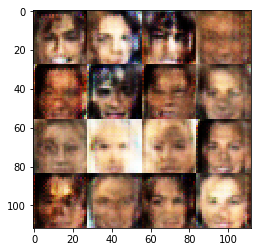

Epoch 0 out of 1 Discriminator loss is: 1.3350 Generator loss is: 0.8510
Epoch 0 out of 1 Discriminator loss is: 1.1813 Generator loss is: 0.8476
Epoch 0 out of 1 Discriminator loss is: 1.6722 Generator loss is: 0.6995
Epoch 0 out of 1 Discriminator loss is: 0.9984 Generator loss is: 1.0010
Epoch 0 out of 1 Discriminator loss is: 1.2220 Generator loss is: 0.5490
Epoch 0 out of 1 Discriminator loss is: 1.1771 Generator loss is: 0.8279
Epoch 0 out of 1 Discriminator loss is: 1.3888 Generator loss is: 0.6051
Epoch 0 out of 1 Discriminator loss is: 1.5047 Generator loss is: 0.7077
Epoch 0 out of 1 Discriminator loss is: 1.5226 Generator loss is: 0.6787
Epoch 0 out of 1 Discriminator loss is: 1.4443 Generator loss is: 0.3411


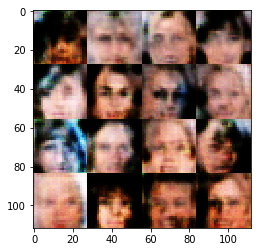

Epoch 0 out of 1 Discriminator loss is: 0.9624 Generator loss is: 1.4723
Epoch 0 out of 1 Discriminator loss is: 1.4521 Generator loss is: 0.9186
Epoch 0 out of 1 Discriminator loss is: 1.2821 Generator loss is: 0.7593
Epoch 0 out of 1 Discriminator loss is: 1.5568 Generator loss is: 0.4189
Epoch 0 out of 1 Discriminator loss is: 1.1431 Generator loss is: 0.7270
Epoch 0 out of 1 Discriminator loss is: 1.1276 Generator loss is: 0.8056
Epoch 0 out of 1 Discriminator loss is: 1.4356 Generator loss is: 0.6279
Epoch 0 out of 1 Discriminator loss is: 1.2781 Generator loss is: 0.6512
Epoch 0 out of 1 Discriminator loss is: 1.3283 Generator loss is: 0.8353
Epoch 0 out of 1 Discriminator loss is: 0.9710 Generator loss is: 1.1090


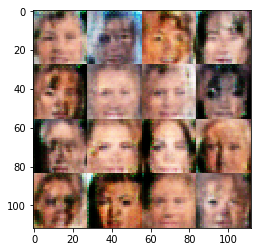

Epoch 0 out of 1 Discriminator loss is: 1.4926 Generator loss is: 0.7329
Epoch 0 out of 1 Discriminator loss is: 1.4138 Generator loss is: 1.2379
Epoch 0 out of 1 Discriminator loss is: 1.3297 Generator loss is: 0.9084
Epoch 0 out of 1 Discriminator loss is: 0.6392 Generator loss is: 1.2882
Epoch 0 out of 1 Discriminator loss is: 1.2021 Generator loss is: 0.8499
Epoch 0 out of 1 Discriminator loss is: 1.5224 Generator loss is: 0.4867
Epoch 0 out of 1 Discriminator loss is: 1.2888 Generator loss is: 0.9580
Epoch 0 out of 1 Discriminator loss is: 1.5629 Generator loss is: 0.3525
Epoch 0 out of 1 Discriminator loss is: 1.3539 Generator loss is: 0.7373
Epoch 0 out of 1 Discriminator loss is: 1.0308 Generator loss is: 0.6434


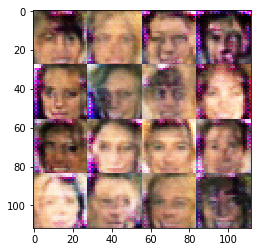

Epoch 0 out of 1 Discriminator loss is: 1.3134 Generator loss is: 0.5603
Epoch 0 out of 1 Discriminator loss is: 1.2839 Generator loss is: 0.5952
Epoch 0 out of 1 Discriminator loss is: 1.6608 Generator loss is: 1.8798
Epoch 0 out of 1 Discriminator loss is: 1.1727 Generator loss is: 0.8249
Epoch 0 out of 1 Discriminator loss is: 1.0873 Generator loss is: 0.9516
Epoch 0 out of 1 Discriminator loss is: 1.3480 Generator loss is: 0.7242
Epoch 0 out of 1 Discriminator loss is: 1.3907 Generator loss is: 0.7126
Epoch 0 out of 1 Discriminator loss is: 1.2941 Generator loss is: 0.4921
Epoch 0 out of 1 Discriminator loss is: 1.2384 Generator loss is: 0.9713
Epoch 0 out of 1 Discriminator loss is: 1.3741 Generator loss is: 0.7222


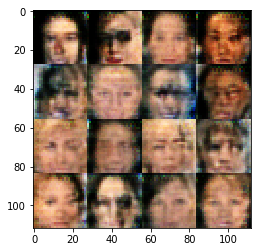

Epoch 0 out of 1 Discriminator loss is: 1.2819 Generator loss is: 0.6749
Epoch 0 out of 1 Discriminator loss is: 1.4513 Generator loss is: 0.7046
Epoch 0 out of 1 Discriminator loss is: 1.4481 Generator loss is: 0.6224
Epoch 0 out of 1 Discriminator loss is: 1.6567 Generator loss is: 0.5701
Epoch 0 out of 1 Discriminator loss is: 1.3734 Generator loss is: 0.6061
Epoch 0 out of 1 Discriminator loss is: 1.3427 Generator loss is: 0.7853
Epoch 0 out of 1 Discriminator loss is: 1.3077 Generator loss is: 0.7624
Epoch 0 out of 1 Discriminator loss is: 1.4204 Generator loss is: 0.7156
Epoch 0 out of 1 Discriminator loss is: 1.3817 Generator loss is: 0.8354
Epoch 0 out of 1 Discriminator loss is: 1.5291 Generator loss is: 0.4804


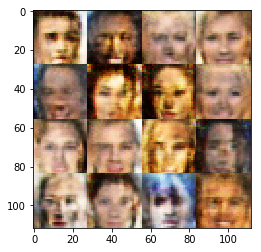

Epoch 0 out of 1 Discriminator loss is: 1.3864 Generator loss is: 0.7840
Epoch 0 out of 1 Discriminator loss is: 1.2410 Generator loss is: 0.7115
Epoch 0 out of 1 Discriminator loss is: 1.3999 Generator loss is: 0.5923
Epoch 0 out of 1 Discriminator loss is: 1.4208 Generator loss is: 0.7516
Epoch 0 out of 1 Discriminator loss is: 1.3088 Generator loss is: 0.4939
Epoch 0 out of 1 Discriminator loss is: 1.4481 Generator loss is: 0.7013
Epoch 0 out of 1 Discriminator loss is: 1.2635 Generator loss is: 0.7955
Epoch 0 out of 1 Discriminator loss is: 1.3836 Generator loss is: 0.6852
Epoch 0 out of 1 Discriminator loss is: 1.3868 Generator loss is: 0.6318
Epoch 0 out of 1 Discriminator loss is: 1.2862 Generator loss is: 0.5600


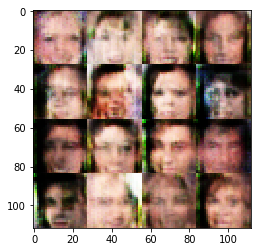

Epoch 0 out of 1 Discriminator loss is: 1.4231 Generator loss is: 1.1147
Epoch 0 out of 1 Discriminator loss is: 1.2451 Generator loss is: 0.9376
Epoch 0 out of 1 Discriminator loss is: 1.3455 Generator loss is: 0.6627
Epoch 0 out of 1 Discriminator loss is: 1.2430 Generator loss is: 0.6715
Epoch 0 out of 1 Discriminator loss is: 1.3487 Generator loss is: 0.8032
Epoch 0 out of 1 Discriminator loss is: 1.3608 Generator loss is: 0.5040
Epoch 0 out of 1 Discriminator loss is: 1.2136 Generator loss is: 0.5522
Epoch 0 out of 1 Discriminator loss is: 1.4487 Generator loss is: 0.4342
Epoch 0 out of 1 Discriminator loss is: 1.4123 Generator loss is: 0.5480
Epoch 0 out of 1 Discriminator loss is: 1.5570 Generator loss is: 1.6379


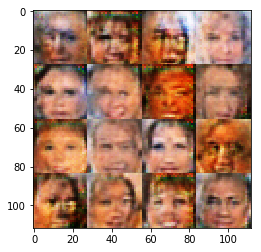

Epoch 0 out of 1 Discriminator loss is: 1.1296 Generator loss is: 0.6983
Epoch 0 out of 1 Discriminator loss is: 1.4174 Generator loss is: 0.6039
Epoch 0 out of 1 Discriminator loss is: 1.3675 Generator loss is: 0.6162
Epoch 0 out of 1 Discriminator loss is: 1.4083 Generator loss is: 0.6115
Epoch 0 out of 1 Discriminator loss is: 1.4445 Generator loss is: 0.6838
Epoch 0 out of 1 Discriminator loss is: 1.3984 Generator loss is: 0.8423
Epoch 0 out of 1 Discriminator loss is: 1.1598 Generator loss is: 0.7527
Epoch 0 out of 1 Discriminator loss is: 1.4897 Generator loss is: 0.6085
Epoch 0 out of 1 Discriminator loss is: 1.3990 Generator loss is: 0.6072
Epoch 0 out of 1 Discriminator loss is: 1.1391 Generator loss is: 0.5790


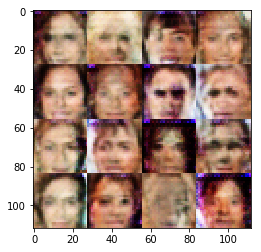

Epoch 0 out of 1 Discriminator loss is: 1.5314 Generator loss is: 0.7463


In [48]:
batch_size=64
z_dim=128
learning_rate=0.001
beta1=0.5

epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(directory, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)